In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model
import interp_helpers as interp
import utils.file_management as fm
%load_ext autoreload
%autoreload 2

sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 11,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })

In [2]:
from feature_attribution import AttributionAnalyzer

In [3]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

run = 36 # fm.get_latest_run()
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

Using cpu device


In [4]:
T = model_info['dataloader']['Sequence length (T)']

num_sequences = 300
events, sequences, counts = interp.get_common_sequences(T, run=run, k=num_sequences)
print(f"Analyzing {num_sequences} sequences:\n{sequences[:20]}")

block_sequences  = interp.get_block_transition_sequences(events, T, high_port=1)
block_sequences = [list(b.values) for b in block_sequences]

Analyzing 300 sequences:
['LLLLLL', 'RRRRRR', 'LLLLLl', 'RRRRRr', 'LLLLlL', 'RRRRrR', 'LLLlLL', 'LLlLLL', 'RRRrRR', 'LlLLLL', 'RRrRRR', 'lLLLLL', 'RrRRRR', 'rRRRRR', 'rLLLLL', 'lRRRRR', 'rrLLLL', 'llRRRR', 'RRRRrr', 'LLLLll']


In [5]:
analyzer = AttributionAnalyzer(model, method='inputs')

## Embedding erasure attribution

Set activations for a particular input token at position $i$ within the sequence to 0 __after__ embedding the token (to bypass the challenge of finding a neutral token with which to mask the token).

Compute the difference between the logit predicted by the output layer of the model for a given target token with and without the token at position $i$ in the sequence.

Optionally, call the function to return the difference in probabilities instead of logits, which seems more interpretable (?) because then the difference can simply be read as the change in probability of predicting the target token, given the inclusion of the input token.

**To address**: Does this truly avoid the challenge posed by finding a neutral mask as a raw input token? It seems that perhaps the model is still biased by perturbing the token embeddings.

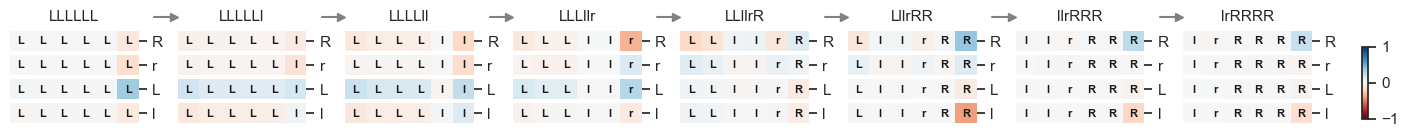

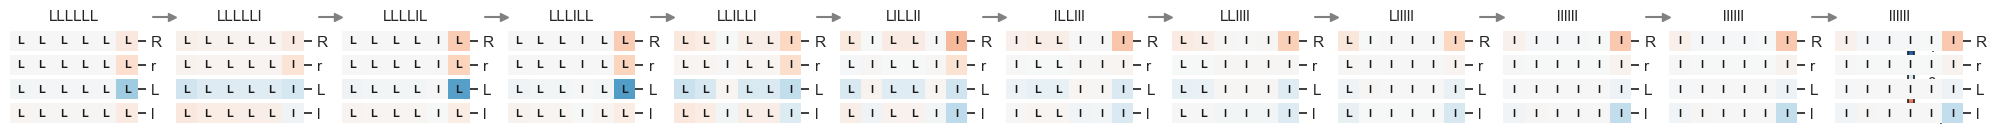

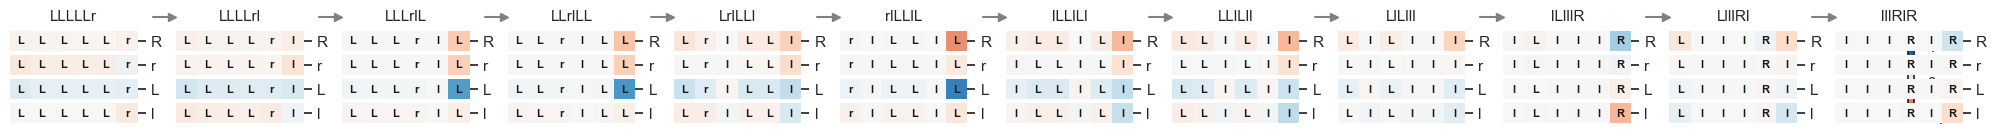

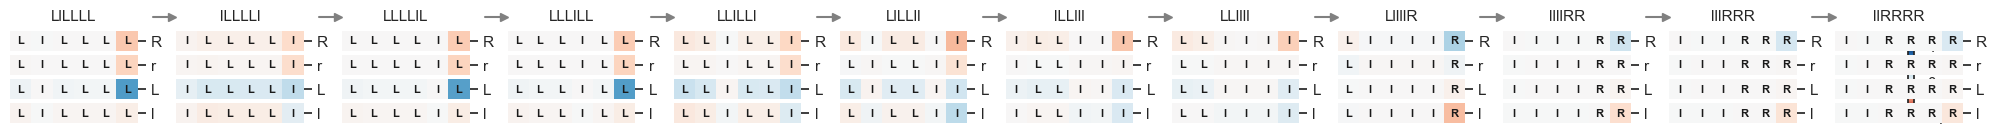

In [6]:
for i, seq in enumerate(block_sequences[10:14], start=10):
    seq_ = interp.trim_leading_duplicates(seq)
    fig, axs = analyzer.plot_attribution_contiguous_sequences(seq_, method='embedding_erasure', as_prob=True)
    fig_path = fm.get_experiment_file(f'embedding_erasure.png', run, subdir=f'interp/bt_{i}')
    fig.savefig(fig_path, bbox_inches='tight')

## Contrastive attribution

As an alternative to the above approach, instead of masking each input token, we instead compare the inclusion of each input token to a "baseline" defined by the average of the logits/probabilities when replacing that token with all other tokens in the vocabulary.

Clearly, this approach will become quite computationally expensive if the vocabulary or sequence length grows, but at least seems theoretically sound(?) and is doable for our small version of the model/task.

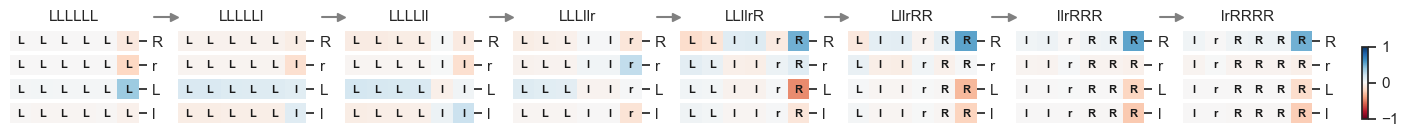

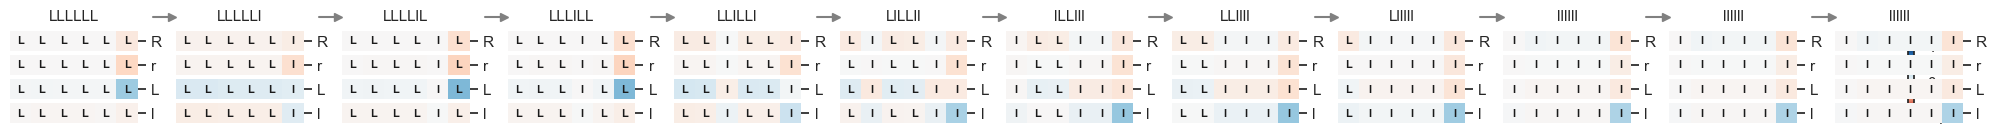

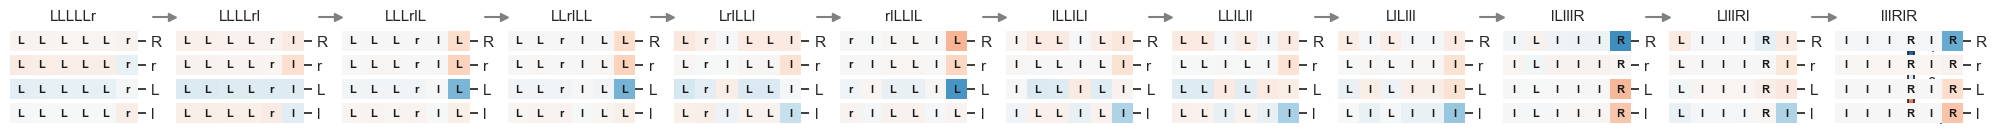

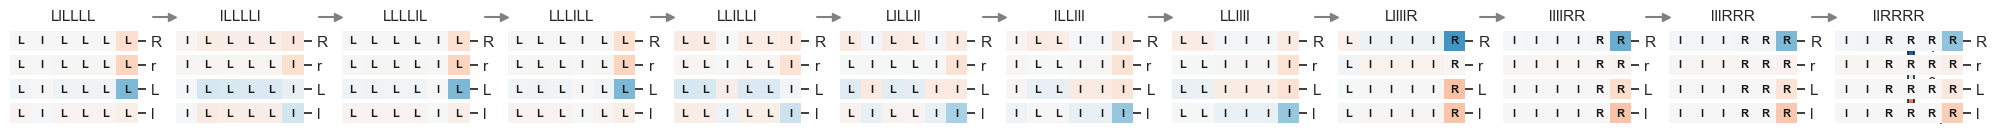

In [7]:
for i, seq in enumerate(block_sequences[10:14], start=10):
    seq_ = interp.trim_leading_duplicates(seq)
    fig, axs = analyzer.plot_attribution_contiguous_sequences(seq_, method='contrastive', as_prob=True)
    fig_path = fm.get_experiment_file(f'contrastive.png', run, subdir=f'interp/bt_{i}')
    fig.savefig(fig_path, bbox_inches='tight')

In [9]:
# analyzer.plot_attribution_all_targets(sequences[:1], method='contrastive', ncols=1, as_prob=True)

## LIME (Local Interpretable Model-agnostic Explanations)

Similar to other methods, begin by computing the baseline prediction from the input sequence for a given target token.

Next, randomly sample a collection of input sequences where each token has some probability of being replaced with a random alternative token from the vocabulary. For each of these perturbed sequences, compute the prediction for the target token. This creates a dataset of perturbed sequences and their corresponding predictions, on which we can then fit a linear model to learn the importance of each token (via fit coefficients).

Given the small size of the vocabulary, this appears to converge to a similar solution as the contrastive attribution approach.

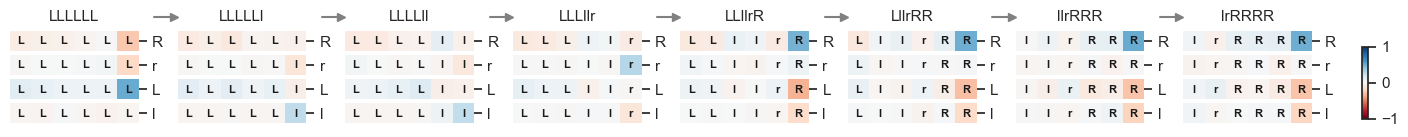

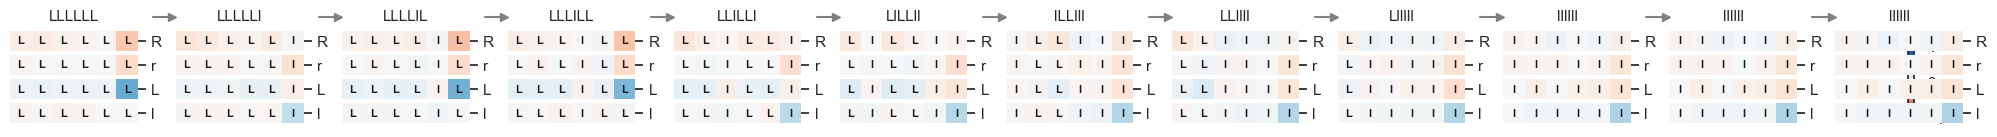

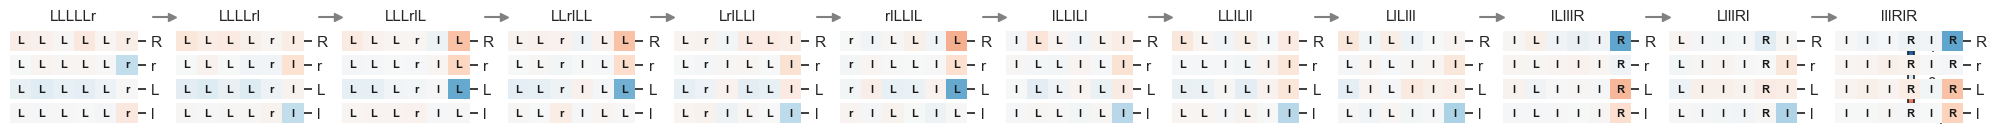

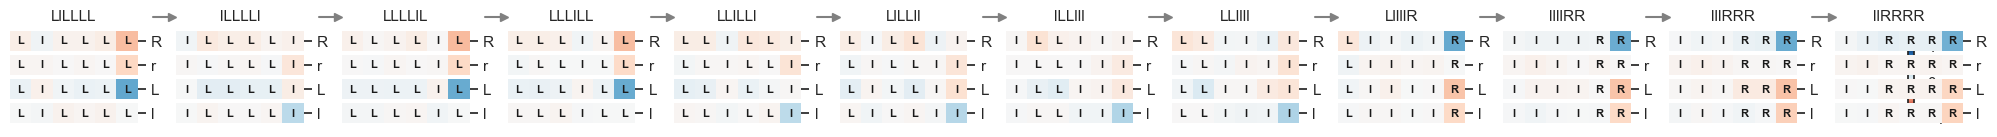

In [10]:
for i, seq in enumerate(block_sequences[10:14], start=10):
    seq_ = interp.trim_leading_duplicates(seq)
    fig, axs = analyzer.plot_attribution_contiguous_sequences(seq_, method='lime')
    fig_path = fm.get_experiment_file(f'lime.png', run, subdir=f'interp/bt_{i}')
    fig.savefig(fig_path, bbox_inches='tight')